# RNN
- Recurrent Neural Net: 순환 신경망
    - 말 그대로 '순환'한다는 의미.
    - 데이터가 순환하는 것인가?
----
#### 순환??
- 순환신경망은 '닫힌 경로'를 가지고 있다.
    - 닫힌 경로라 하면 길이가 정해진 경로인가?
    - 데이터는 이 경로를 따라 쭉 진행하므로 '순환'한다고 볼 수 있다.
        - 혈액을 생각해보자

## BPTT
- RNN에서의 역전파: Backpropagation through time 
    - 시간에 따른 역전파
    - RNN이 '순환'한다고 했을 때, 각 cell을 하나의 time step으로 생각한다면 그 time step을 따라가면서 역전파를 수행.
---
### BPTT의 문제
- RNN의 순전파는 행렬곱 -> '+' -> 'tanh' 통과
- 역전파는 'tanh' -> '+' -> '행렬곱' 통과
    - 왜 항상 tanh를 쓰는지는 정확히 모르겠다. sigmoid보다는 역전파가 더 잘되기 때문에,,? --> tanh의 그래프를 보면 sigmoid보다는 출력의 범위가 넓고, 경사면이 큰 범위가 커서 빠르게 학습?
    - 아무튼, tanh를 미분하면 tanh'(x) = 1 - tanh(x)^2이 된다.
    - 그럼 tanh의 범위는 -1보다 크거나 같고, 1보다 작거나 같다.
        - tanh'의 범위는 항상 1보다 작게됨. ==> 계속 곱하면 0에 가까워지지 않을까?
---
- 그럼 위 내용을 가중치의 관점에서 본다면
    - 'tanh'를 통과하고 '+'통과 ('+'노드는 입력을 그대로 흘려보냄)
    - 마지막으로 '행렬곱'의 역전파가 진행 될 것이다.
    - 은닉층의 출력이 dh이고, 가중치가 Wh라고 할 때, 다음 예시를 통해 가중치가 어떻게 되는지 확인해보자    

In [3]:
import numpy as np
N = 2 #미니배치 크기
H = 3 #은닉 상태 벡터의 차원 수
T = 20 #시계열 데이터의 길이

dh = np.ones((N, H)) #dh: 모든 원소가 1인 2 x 3 행렬
Wh = np.random.randn(H, H)
Wh_list = []
norm_list = []
dh_list = []
print(f"dh:\n {dh}\n")
print(f"Wh: \n{Wh}\n")
for t in range(T):
    dh = np.matmul(dh, Wh.T) #행렬의 역전파 ~ 
    norm = np.sqrt(np.sum(dh**2)) / N 
    #l2 norm을 구하고 N(미니배치 크기)로 나눠줌.
    norm_list.append(norm)
    dh_list.append(dh)
print(f"dh:\n {dh}\n")
print(f"dh list: \n {dh_list} \n")
print(f"norm list: \n{norm_list}\n")

dh:
 [[1. 1. 1.]
 [1. 1. 1.]]

Wh: 
[[-0.68153985 -1.93970896  0.67076229]
 [-1.46036714  0.391873    0.91808671]
 [ 0.36187896  0.73361743 -0.69306025]]

dh:
 [[16765466.71501118 11720113.66583842 -8676609.12453001]
 [16765466.71501118 11720113.66583842 -8676609.12453001]]

dh list: 
 [array([[-1.95048652, -0.15040744,  0.40243614],
       [-1.95048652, -0.15040744,  0.40243614]]), array([[ 1.89101993,  3.15895708, -1.09509405],
       [ 1.89101993,  3.15895708, -1.09509405]]), array([[-8.15081059, -2.52906469,  3.76075245],
       [-8.15081059, -2.52906469,  3.76075245]]), array([[12.9833226 , 14.36480065, -7.41140086],
       [12.9833226 , 14.36480065, -7.41140086]]), array([[-41.68347253, -20.13554885,  20.37320676],
       [-41.68347253, -20.13554885,  20.37320676]]), array([[ 81.13163104,  71.68696606, -43.97602119],
       [ 81.13163104,  71.68696606, -43.97602119]]), array([[-223.84374699, -130.76358237,  112.42867045],
       [-223.84374699, -130.76358237,  112.42867045]]), ar

- $y$가 출력이고, 손실함수가 $L$이라면
    - $\partial L \over \partial \bf x$ = ${\partial L \over \partial \bf y}  \dot \bf W^T$(행렬의 역전파)
    - 위 식을 그대로 구현한 것은 아래와 같다.
    ```python
    dh = np.matmul(dh, Wh.T)
    ```
    - dh가 얼마나 큰지 확인해보자
    ```python
    np.sqrt(np.sum(dh**2)) #l2 norm을 계산 << dh(벡터)의 크기를 계산
    np.sqrt(np.sum(dh**2)) / N #l2 norm을 배치크기(N)으로 나눠줌
    
    ```
    - 위 코드의 출력을 보면, dh가 꾸준히 증가한다.
        - time step을 거슬러 올라갈수록 dh가 지수적으로 증가한다. 
        - 상류로부터 흘러오는 기울기 dh를 연쇄법칙에 의해 계속해서 곱하게 되는데, 그럼 기울기가 커지다 못해 '폭발'해버릴것!!\
        ---
            - 참고로, Wh가 스칼라인 경우 1보다 크면 지수적으로 증가, 1보다 작음면 지수적으로 감소한다.
            - 그리고 Wh가 행렬인 경우 '특잇값'을 척도로, 특잇값의 최대값이 1보다 크면 지수적으로 증가, 1보다 작으면 지수적으로 감소한다.
            - (반드시 그런 것은 아니고, 그럴 가능성이 높다는 말입니다,,ㅎ) ~ difficulty of training RNN이라는 논문에 잘 나와있는 것 같네용
        ---
        - 지금은 이해가 안가더라도 나중에 backward 코드를 보면 이해가 갈 수도 있어!

### RNN의 미니배치 학습
- RNN에서 미니배치 학습은 어떨까?
    - 정석대로 하면, 데이터의 순서를 고려해야 하기 때문에, 입력되는 데이터 순서에 맞게 위치를 '조정'해야한다.
    - RNN은 다른 신경망에서와 다르게 '무작위'로 미니 배치를 하는 것이 아니라, '순서대로' 끊어서 각각의 미니배치를 만들어줘야함. 
        - 특히, truncated bptt를 사용한다면!
        
 

## RNN의 구현


In [4]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1- h_next ** 2)
        db = np.sum(dt, axis = 0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

### 코드 뜯어보기 ① class __ init__
```python
class RNN:
    def __init__(self, Wx, Wh, b): 
```
- RNN class는 Wx, Wh, b를 인자로 받는다. __init__은 초기화 하는 메소드
---
```python
        self.params = [Wx, Wh, b]
```
- 인스턴스 변수(self.params)에 클래스 생성시 받은 인자 Wx, Wh, b를 리스트 형태로 저장한다
---
```python
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
```
- 기울기를 다 0으로 초기화. np.zeros_like(a)는 a와 같은 size의 0으로 채워진 텐서(행렬)를 만든다.
--- 
```python
        self.cache = None
```
- backpropagation 계산할 때 필요한 데이터를 담을 변수를 만들어준다.
---

### 코드 뜯어보기 ② forward
```python
    def forward(self, x, h_prev):
```
- forward 메소드는 x와 h_prev를 인수로 받는다.
    - x는 해당 time step의 입력(input)이 될 것이고, h_prev는 직전 은닉층의 출력이 될 것이다.
```python
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
```
- 순전파 계산식이다.
    - 직전 은닉층의 출력(h_prev)와 가중치(Wh)를 곱하고(행렬곱)
    - 현재 time step의 입력(x)와 가중치(Wx)를 곱한(행렬곱) 다음 편향 b를 더한다.
```python
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
```
- 마지막으로, 계산한 t 값을 하이퍼볼릭 탄젠트(tanh)에 넣어 계산한다.
    - time step의 input인 x와, 직전 은닉층의 출력 h_prev와 현재 time step은닉층의 출력 h_next를 역전파를 위한 cache에 튜플 형태로 저장한다.
    - forward 메소드는 h_next를 리턴한다.
--------------


- RNN의 역전파(출처: 밑바닥부터 시작하는 딥러닝2, p214)
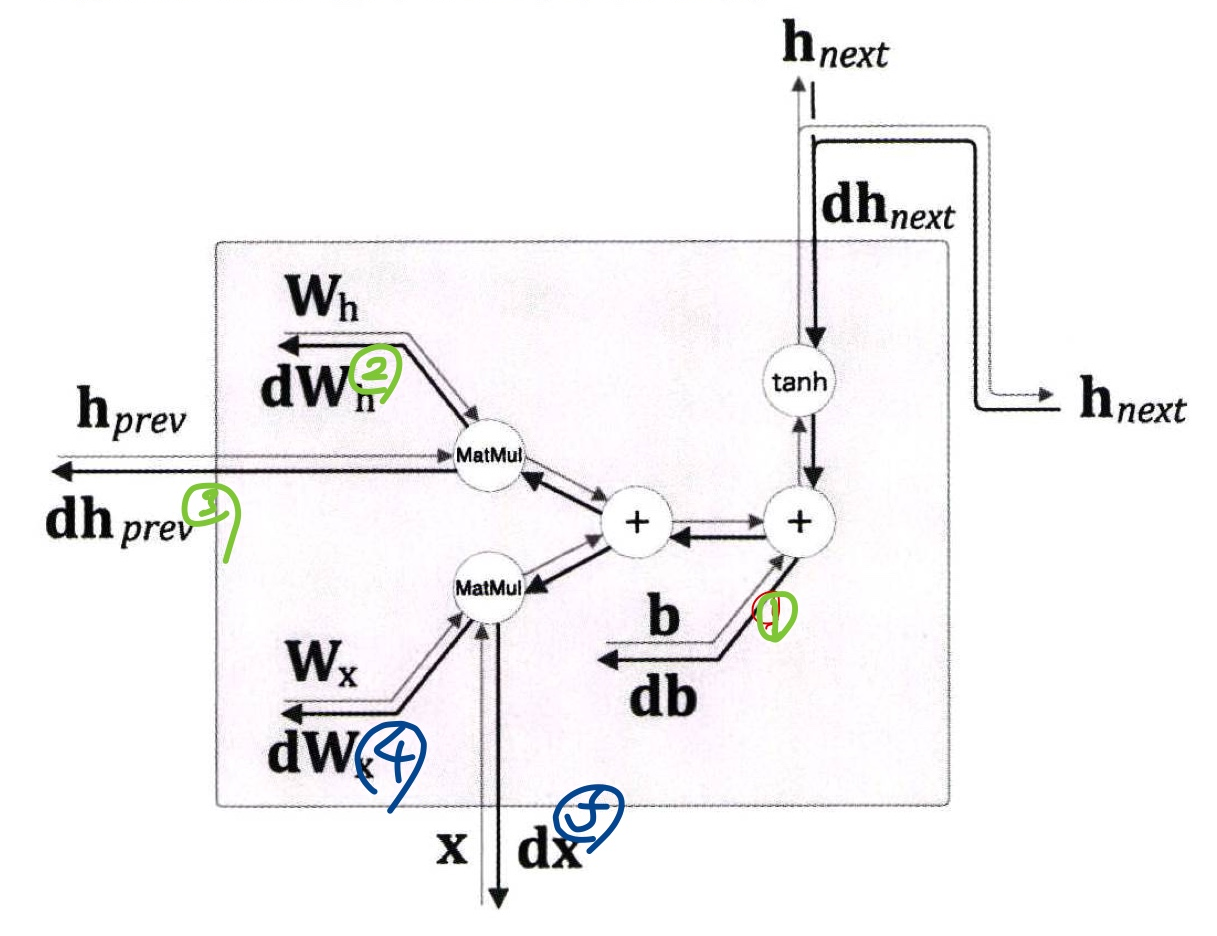

### 코드 뜯어보기 ③ backward
```python
def backward(self, dh_next):
    Wx, Wh, b = self.params
```
- class 객체 선언시 입력한 인자들을 리스트로 묶어놓았던 것이self.params이고 이것을 다시 Wx, Wh, b로 풀어준다.
---
```python
    x, h_prev, h_next = self.cache
```
- forward에서 self.cache에 저장해 놓았던 값들을 풀어준다
---
```python
    dt = dh_next * (1- h_next ** 2)
```
- 여기서 잘 이해가 안가서 조금 더 자세히 살펴보았다.
    ```python
         t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    ```
    - t는 위의 식으로 계산되는 값이었다. 
    - 여기에 tanh를 계산한 값이 h_next이다. 그 h_next를 이용하여 어떤 손실함수 $L$을 계산한다고 하면, 그 미분은 아래와 같이 정의할 수 있다.(연쇄법칙)
         - $\partial L \over \partial t$ = ${\partial L \over \partial h_{next}} \cdot {\partial h_{next} \over \partial t}$ ~ t가 입력이므로!<br><br>
- 하이퍼볼릭 탄젠트(tanh)의 미분은 $tanh'({ x}) = 1-tanh({\bf x})^2 $임을 기억하자
    - dh_next는 backward함수 실행 시 인자로 받은 값이다. 
    - 위의 연쇄법칙 식에서 dh_next는 ${\partial L \over \partial h_{next}}$에 해당한다
    - $\partial L \over \partial t$ = dt라 하면, 코드의 (1- h_next ** 2) 는 ${\partial h_{next} \over \partial t}$가 된다.
---
```python
    db = np.sum(dt, axis = 0)
```
- 편향에 대한 역전파를 의미한다. 
    - 합의 역전파는 그대로 값을 흘려보낸다. 
---
```python
    dWh = np.matmul(h_prev.T, dt)
```
- 행렬의 역전파다. 
    - 반대편 행렬의 전치(h_prev.T)와 흘러오는 미분값 dt를 곱해준다.
    - 자세히 살펴보면 연쇄법칙의 연속이다.
---
```python
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)
```
- 행렬의 역전파다. 위 코드와 동일한 방식으로 이해할 수 있다.

## T개의 RNN 계층을 가진 RNN 구현
- 위에서 본 RNN은 하나의 cell에 대한 구현이었다.
    - NLP에서 RNN의 경우, 입력은 어떤 문장이 되는데, 단어를 임베딩 벡터로 표현한다면 문장은 하나의 행렬이 될 것이다.
    - 따라서 여러 벡터들을 연달아서 처리하게 되는데, 하나의 cell이 연속적으로 호출되어 forward, backward를 계산한다.

In [7]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful =stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layers.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] =  grad
            
        self.dh = dh
        return dxs

### 코드 뜯어보기 ① TimeRNN, __ init__, stateful
- 기존 RNN코드랑 같은 부분은 설명하지 않겠음.
- 여기서는 init함수에 dh, stateful이 추가되었다.
    - dh는 나중에 보자! 일단 class객체 생성시 존재한다는 것은 알자
- stateful: 상태에 대한 정보를 의미한다.
    - Tensorflow나 pytorch의 RNN경우에도 인자에 stateful이 존재하는 경우가 있다.
    - 여기서 stateful이란 은닉 상태를 유지할 것인가를 의미한다.
    - 실제로 forward에서 보면
    ```python
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
    ```
    - stateful이 False인 경우 RNN의 은닉상태(h)를 전부 N x H 모양의 영행렬로 초기화한다.
---
```python 
    def reset_state(self):
        self.h = None
```
- 은닉상태(h)를 제거한다. (reset한다)
---

### 코드 뜯어보기 ② foward
```python
        N, T, D = xs.shape
        D, H = Wx.shape
```
- xs는 입력. 입력의 형상이 N, T, D가 된다.
    - 당연하게도 N은 미니배치의 크기, D는 입력 벡터의 차원수
    - T는 행: 즉 D차원의 벡터 T개
- D, H는 가중치의 shape
---
```python
        self.layers = []
```
- 객체의 인스턴스 변수 layers를 빈 리스트의 형태로 만들어준다.
    - T개의 rnn층이 위치하게 되지 않을까,,?
---
```python
        hs = np.empty((N, T, H), dtype = 'f')
```
- (N, T, H)모양의 빈 넘파이 배열을 만들어준다.
---
```python
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
```
- stateful이 False이면 은닉상태(h)를 모두 0으로 초기화한다. 
---
```python 
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        return hs
```
- 데이터의 개수(T)만큼 반복한다.
1. layer를 RNN계층으로 생성한다.
    ```python
        *self.params
    ```
    - 를 통해서 self.params = [Wx, Wh, b]로 정의되었던 params를 풀어서, RNN의 인자로 넣어준다.
        - 참고로, RNN의 생성시 인자는 (Wx, Wh, b)이다.
2. 은닉상태를 계산한다.
    - 모든 미니배치, 전체 데이터에서 해당 time step(t)의 순전파를 계산한다.
    - RNN layer의 foward 메소드는 해당 time step의 입력 데이터와 직전 은닉상태를 인자로 받는다.
        - 여기서는 xs[:, t, :]가 해당 time step의 입력데이터고
        - self.h 가 이전 은닉상태에 해당한다
3. 은닉상태를 재정의한다.
    - 다음 은닉층에 넘겨주기 위해, 계산된 self.h를 빈 넘파이 배열인 hs에 넣어준다
4. 해당 층을 list형식의 self.layer에 쌓아준다.
5. for 반복문을 다 돌고나면, forward 메소드는 은닉상태 hs를 반환한다.
---


### 코드 뜯어보기 ③ backward
```python
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layers.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] =  grad
            
        self.dh = dh
        return dxs
``` 
---
- 먼저 단일셀 RNN과 마찬가지로 출력값에 대한 손실함수의 미분값을 입력으로 받는다.(dhs) ~ 직전 은닉상태에 대한 미분값 저장 공간
- (N, T, D) 크기의 빈 넘파이 배열을 만든다.(dxs) ~ 입력에 대한 미분값 저장 공간
- 초기 dh는 0으로 설정하고, grad값을 넘겨줄 리스트를 만든다.([0,0,0])
---
```python
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
```
- T-1에서부터 시작해서 0까지 역순으로 반복문 진행
1. 순전파에서 쌓았던 self.layers의 가장 마지막 층을 layer로 정의한다.
2. RNN층에 대한 역전파를 진행. 
    - TimeRNN의 backward 메소드는 dhs를 인자로 받고, 이 반복문에서 해당 timestep의 역전파를 계산. 
    - layer.backward의 리턴값은 dx, dh_prev이다.
        - dx는 입력에 대한 미분값
        - dh_prev 직전 은닉상태에 대한 미분값
3. 미분값들을 모아놓은 dxs에 해당 time step의 입력에 대한 미분값을 저장한다.
---
```python
            for i, grad in enumerate(layers.grads):
                grads[i] += grad
```
- enumerate로 index와 value를 동시에 불러온다.
    - [0, 0, 0]으로 정의했던 grads의 i번째 index에 layer의 grad값을 더해준다.
    - 참고로 layers.grads는 
    ```python
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
     ```
     - 이런 값을 가진다.
     - 즉, 각 셀에서 입력, 가중치, 편향에 대한 미분값을 저장한다.
---
```python
        for i, grad in enumerate(grads):
            self.grads[i][...] =  grad
```
- grads에는 layers.grads의 값들이 저장되어 있다. 
    - 이 값들을 TimeRNN의 self.grad에 저장해준다.
---
```python
        self.dh = dh
        return dxs
```
- 마지막으로 직전 은닉상태에 대한 미분값 dh를 지정해주고 dxs를 반환한다.